In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
arima = pd.read_csv('/Users/louiserigal/Documents/Data Science/Portfolio/Final NHH/Churn & CLV/arima_data.csv', sep = ';')

In [5]:
arima.head()

,ID,Month,Year,Age,Gender,HHIncome,HHSize,RelationshipL,DM,TV_Adv,Facebook_Adv,Publicity,Web_Visits,Facebook_Page_Views,churnD
0,10569,12,2012,43,Female,36943,2,0,0,21567.49,29841.457419,35,4340,333,0
1,10569,1,2013,44,Female,36943,2,1,0,227.99,32299.680387,36,6837,320,1
2,13228,1,2012,72,Female,23296,2,0,0,0.00,42143.807849,23,9336,368,0
3,13228,2,2012,72,Female,23296,2,1,0,0.00,28065.755478,22,8716,381,1
4,13516,1,2012,33,Male,26272,2,0,0,0.00,42143.807849,23,9336,368,0


In [7]:
def visualisations(y_test, y_pred, y_proba) :
    plt.figure(figsize = (10,3))
    plt.subplot(121)
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.xlabel('Prédictions')
    plt.ylabel('Observations')
    plt.title('Matrice de confusion')
    
    plt.subplot(122)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [9]:
def prediction(model, X_train, y_train, y_test) :
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    return y_pred, y_proba

In [11]:
def evaluation_metrics(y_test, y_pred, y_proba) :
    print("\nClassification Report :")
    print(classification_report(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_proba))

In [34]:
# Independant and Dependant variables selection
y = arima['churnD']
X = arima[['DM', 'TV_Adv', 'Facebook_Adv', 'Publicity']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

BASIC MODELLING


Classification Report :
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      6038
           1       0.00      0.00      0.00       348

    accuracy                           0.95      6386
   macro avg       0.47      0.50      0.49      6386
weighted avg       0.89      0.95      0.92      6386

AUC-ROC: 0.6681724556734551


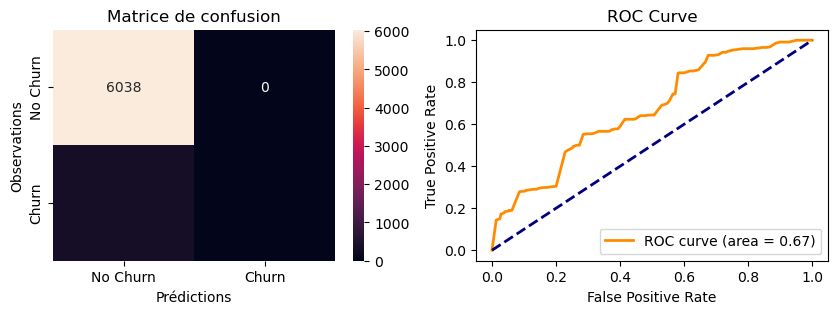

In [16]:
clf = LogisticRegression()
y_pred, y_proba = prediction(clf, X_train, y_train, y_test)

evaluation_metrics(y_test, y_pred, y_proba)

visualisations(y_test, y_pred, y_proba)

GREAT IMBALANCE OF THE DV IN THE DATASET - CLASS WEIGHT


Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.56      0.71      6038
           1       0.08      0.64      0.14       348

    accuracy                           0.56      6386
   macro avg       0.52      0.60      0.42      6386
weighted avg       0.92      0.56      0.68      6386

AUC-ROC: 0.6686167205400281


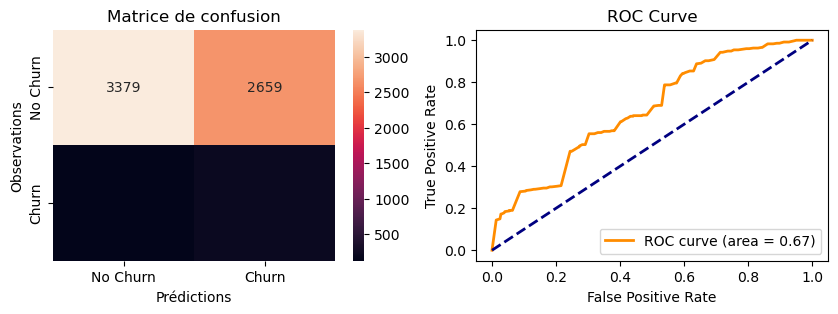

In [19]:
clf_balanced = LogisticRegression(class_weight="balanced", random_state=42)

y_pred, y_proba = prediction(clf_balanced, X_train, y_train, y_test)

evaluation_metrics(y_test, y_pred, y_proba)

visualisations(y_test, y_pred, y_proba)

Decision Trees


Classification Report :
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      6038
           1       0.18      0.80      0.29       348

    accuracy                           0.79      6386
   macro avg       0.58      0.79      0.59      6386
weighted avg       0.94      0.79      0.85      6386

AUC-ROC: 0.8547803565921577


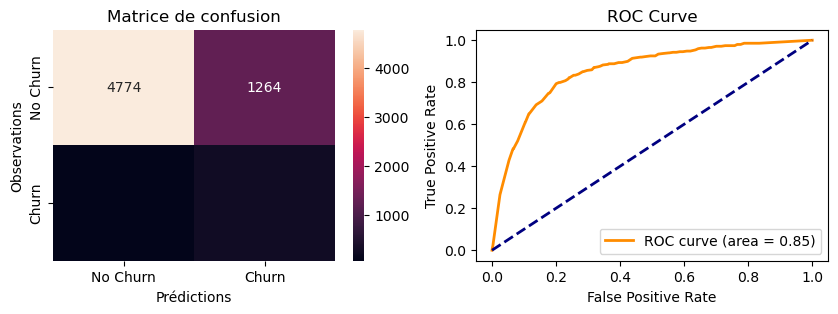

In [22]:
# model - random forest
rf_balanced = RandomForestClassifier(class_weight = 'balanced')

y_pred, y_proba = prediction(rf_balanced, X_train, y_train, y_test)
evaluation_metrics(y_test, y_pred, y_proba)
visualisations(y_test, y_pred, y_proba)
# our results are already way better with a random forest

SVM


Classification Report :
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      6038
           1       0.14      0.79      0.23       348

    accuracy                           0.72      6386
   macro avg       0.56      0.75      0.53      6386
weighted avg       0.94      0.72      0.80      6386

AUC-ROC: 0.787023896547917


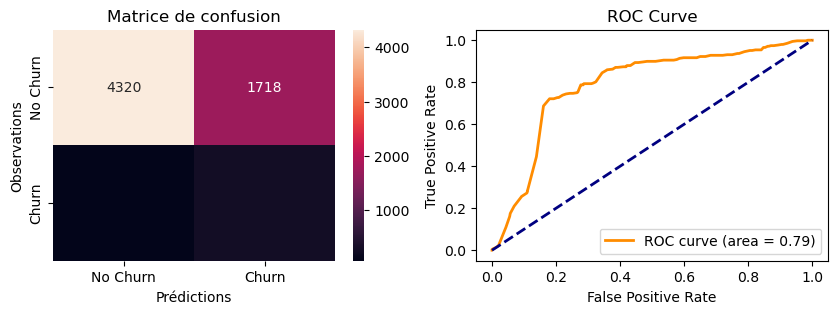

In [40]:
svm_balanced = SVC(probability = True, class_weight = 'balanced') # default kernel is rbf and is not linear

y_pred, y_proba = prediction(svm_balanced, X_train, y_train, y_test)
evaluation_metrics(y_test, y_pred, y_proba)
visualisations(y_test, y_pred, y_proba)

Data Resampling - SMOTE (Synthetic Minority Oversampling Technique)

In [25]:
# Divide data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE on our train data, but not too much in order to show that an imbalanced is acceptable
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Scaling our IVs
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.57      0.71      6038
           1       0.08      0.64      0.14       348

    accuracy                           0.57      6386
   macro avg       0.52      0.60      0.43      6386
weighted avg       0.92      0.57      0.68      6386

AUC-ROC: 0.6704832516666476


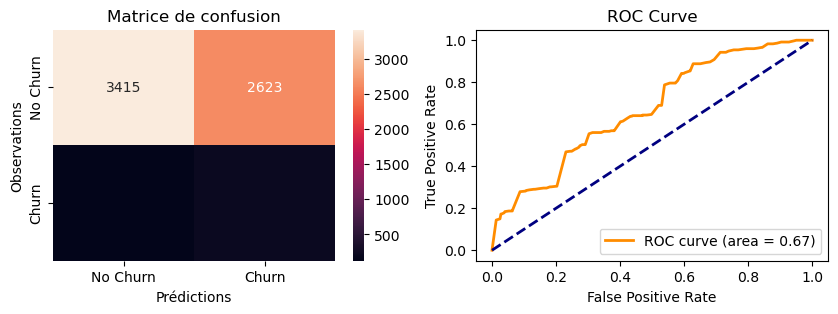

In [27]:
clf_smote = LogisticRegression()

y_pred, y_proba = prediction(clf_smote, X_train, y_train, y_test)

evaluation_metrics(y_test, y_pred, y_proba)

visualisations(y_test, y_pred, y_proba)


Classification Report :
              precision    recall  f1-score   support

           0       0.98      0.82      0.90      6038
           1       0.19      0.74      0.31       348

    accuracy                           0.82      6386
   macro avg       0.59      0.78      0.60      6386
weighted avg       0.94      0.82      0.86      6386

AUC-ROC: 0.8511331966510948


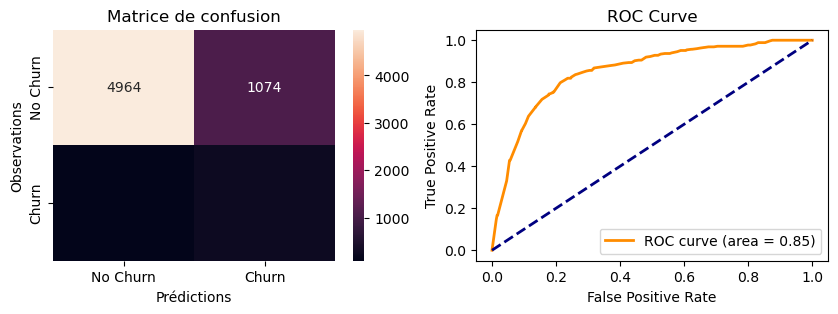

In [29]:
# model - gradient boosting
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', 
                              learning_rate=0.1, n_estimators=100, max_depth=3)

y_pred, y_proba = prediction(xgb_model, X_train, y_train, y_test)
evaluation_metrics(y_test, y_pred, y_proba)
visualisations(y_test, y_pred, y_proba)

UNDERSAMPLING

In [25]:
X = arima[['DM', 'TV_Adv', 'Facebook_Adv', 'Publicity']] # IVs
y = arima['churnD']                # DV

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Divide data into train/test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scaling our IVs
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


Classification Report :
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       371
           1       0.54      0.71      0.61       320

    accuracy                           0.59       691
   macro avg       0.60      0.59      0.58       691
weighted avg       0.60      0.59      0.58       691

AUC-ROC: 0.6524385107816711


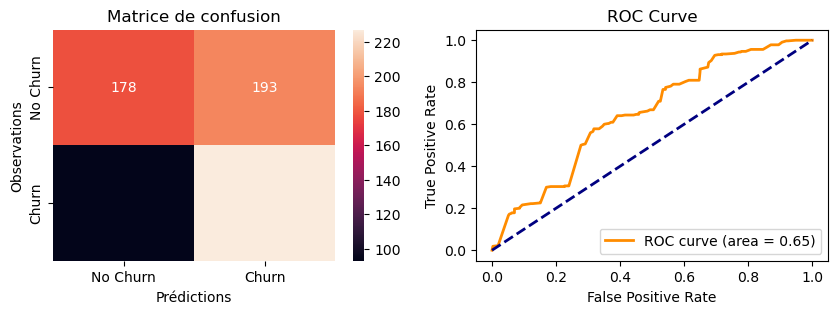

In [26]:
clf_under = LogisticRegression()

y_pred, y_proba = prediction(clf_under, X_train, y_train, y_test)

evaluation_metrics(y_test, y_pred, y_proba)

visualisations(y_test, y_pred, y_proba)

IVs without Publicity


Classification Report :
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      6038
           1       0.00      0.00      0.00       348

    accuracy                           0.95      6386
   macro avg       0.47      0.50      0.49      6386
weighted avg       0.89      0.95      0.92      6386

AUC-ROC: 0.6697117965528664


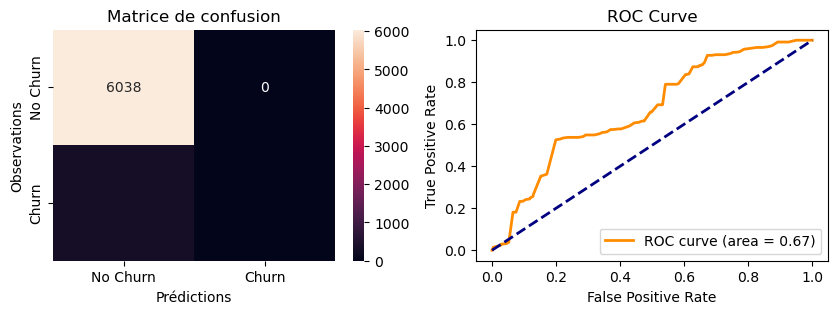

In [29]:
# Independant and Dependant variables selection
y = arima['churnD']
X = arima[['DM', 'TV_Adv', 'Facebook_Adv']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression()
y_pred, y_proba = prediction(clf, X_train, y_train, y_test)

evaluation_metrics(y_test, y_pred, y_proba)

visualisations(y_test, y_pred, y_proba)

IVs without DM


Classification Report :
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      6038
           1       0.00      0.00      0.00       348

    accuracy                           0.95      6386
   macro avg       0.47      0.50      0.49      6386
weighted avg       0.89      0.95      0.92      6386

AUC-ROC: 0.6722036774756046


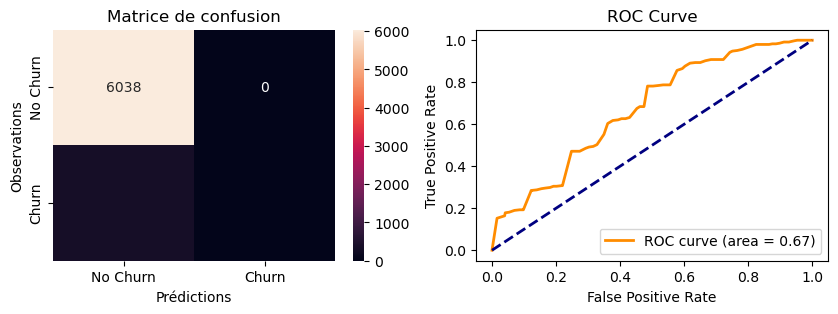

In [32]:
# Independant and Dependant variables selection
y = arima['churnD']
X = arima[['Publicity', 'TV_Adv', 'Facebook_Adv']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression()
y_pred, y_proba = prediction(clf, X_train, y_train, y_test)

evaluation_metrics(y_test, y_pred, y_proba)

visualisations(y_test, y_pred, y_proba)

IVs without DM and Publicity


Classification Report :
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      6038
           1       0.00      0.00      0.00       348

    accuracy                           0.95      6386
   macro avg       0.47      0.50      0.49      6386
weighted avg       0.89      0.95      0.92      6386

AUC-ROC: 0.6649945460360247


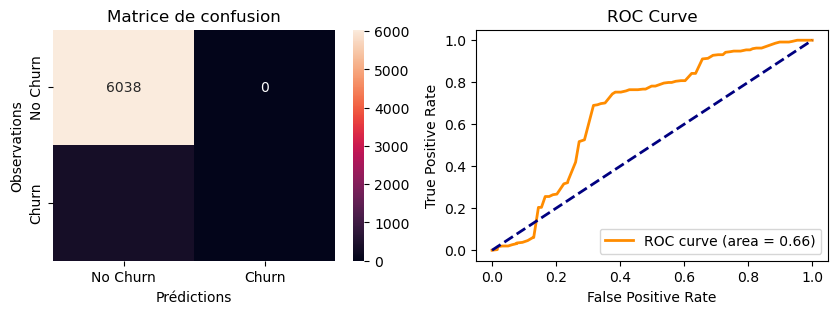

In [35]:
# Independant and Dependant variables selection
y = arima['churnD']
X = arima[['TV_Adv', 'Facebook_Adv']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression()
y_pred, y_proba = prediction(clf, X_train, y_train, y_test)

evaluation_metrics(y_test, y_pred, y_proba)

visualisations(y_test, y_pred, y_proba)

ALL VARIABLES _ Undersampling

In [42]:
# Independant and Dependant variables selection
y = arima['churnD']
X = arima.drop(columns = 'churnD', axis = 1)

label = LabelEncoder()
label.fit(['Male', 'Female'])
X['Gender'] = label.transform(X['Gender'])

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Logistic Regression


Classification Report :
              precision    recall  f1-score   support

           0       0.81      0.68      0.74       371
           1       0.69      0.82      0.75       320

    accuracy                           0.74       691
   macro avg       0.75      0.75      0.74       691
weighted avg       0.75      0.74      0.74       691

AUC-ROC: 0.8097456199460915


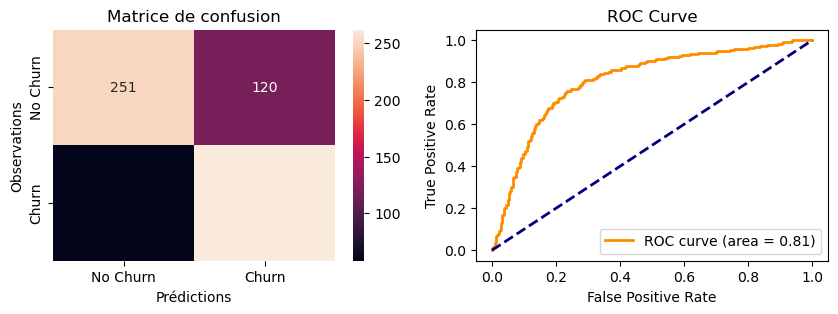

In [44]:
clf = LogisticRegression()
y_pred, y_proba = prediction(clf, X_train, y_train, y_test)

evaluation_metrics(y_test, y_pred, y_proba)

visualisations(y_test, y_pred, y_proba)

Random Forest


Classification Report :
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       371
           1       0.79      0.80      0.79       320

    accuracy                           0.81       691
   macro avg       0.80      0.81      0.81       691
weighted avg       0.81      0.81      0.81       691

AUC-ROC: 0.8571639150943396


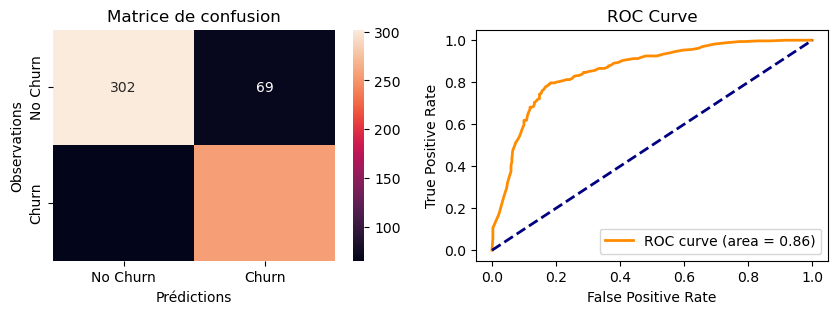

In [46]:
y_pred, y_proba = prediction(rf_balanced, X_train, y_train, y_test)

evaluation_metrics(y_test, y_pred, y_proba)

visualisations(y_test, y_pred, y_proba)

XGBoost


Classification Report :
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       371
           1       0.80      0.81      0.80       320

    accuracy                           0.82       691
   macro avg       0.82      0.82      0.82       691
weighted avg       0.82      0.82      0.82       691

AUC-ROC: 0.8660966981132076


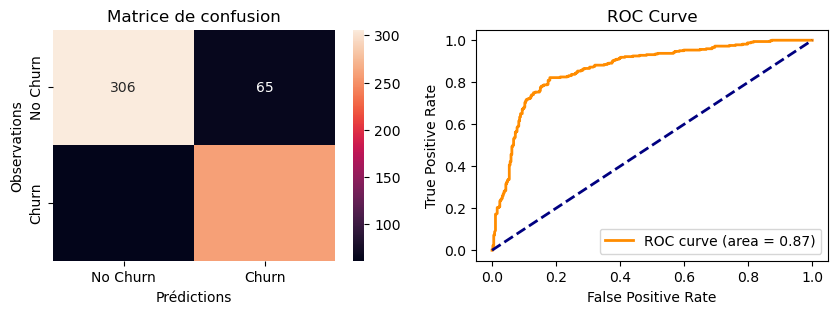

In [50]:
y_pred, y_proba = prediction(xgb_model, X_train, y_train, y_test)
evaluation_metrics(y_test, y_pred, y_proba)
visualisations(y_test, y_pred, y_proba)

SVM


Classification Report :
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       371
           1       0.77      0.79      0.78       320

    accuracy                           0.79       691
   macro avg       0.79      0.79      0.79       691
weighted avg       0.80      0.79      0.79       691

AUC-ROC: 0.8305256064690028


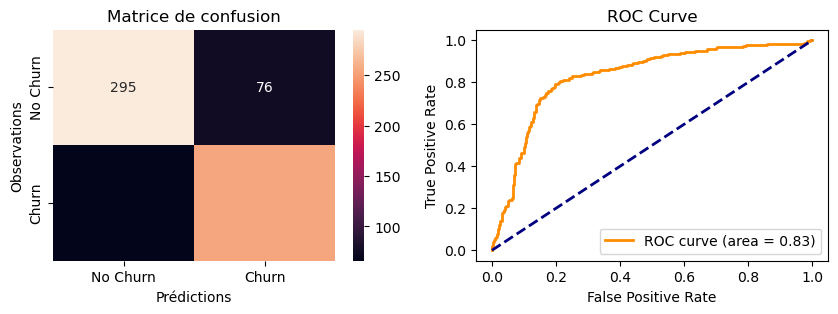

In [56]:
y_pred, y_proba = prediction(svm_balanced, X_train, y_train, y_test)
evaluation_metrics(y_test, y_pred, y_proba)
visualisations(y_test, y_pred, y_proba)